In this notebook, we will calculate features using Trotterization with a noisy classical simulator (AerSimulator)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
# GPU check
!nvidia-smi -L

In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import os
from fourier_learning_ibm.heisenberg import (
    HeisenbergModel,
    get_graph,
    get_positions,
    # get_initial_layout,
    # get_prob0,
)
from fourier_learning_ibm.setup import setup_backend
from fourier_learning_ibm.helper_features import run_job, get_features
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Batch
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
import pickle
import networkx as nx
from datetime import datetime, timezone
import json
import math

In [4]:
import warnings

warnings.filterwarnings("ignore")

### Config backend 

In [5]:
# density matrix simulator
backend_qpu, backend_dm_noiseless, backend_dm_noisy = setup_backend(
    qpu_name="ibm_marrakesh", device="GPU", method="density_matrix"
)

Using backend QPU: <IBMBackend('ibm_marrakesh')>

NoiseModel:
  Basis gates: ['cz', 'delay', 'for_loop', 'id', 'if_else', 'measure', 'reset', 'rz', 'switch_case', 'sx', 'x']
  Instructions with noise: ['measure', 'sx', 'reset', 'x', 'cz', 'id']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155]
  Specific qubit errors: [('sx', (0,)), ('sx', (1,)), ('sx', (2

### Prepare parameters and load dataset

In [6]:
n_qubits = 12
# C = 3 * (n_qubits - 1)
C = 3
threshold = 0.6

# Load dataset (orient="records")
df_n_step = pd.read_json(
    f"results/get_param/{n_qubits}Q/threshold{threshold:.2f}/optimal_n_step.json",
    orient="records",
)
n_samples = 55

# Note that K = n_features-1.
# n_features counts only the number of real features, also the one of t=0, i.e., constant term.
# The number of all features, including imaginary numbers, is 2K+1.
n_features = len(df_n_step)

times = df_n_step["t"].values

display(df_n_step)
print(f"n_qubits: {n_qubits}")
print(f"C: {C}")
print(f"threshold: {threshold}")
print(f"n_samples: {n_samples}")
print(f"n_features: {n_features}")
print(f"times: {times}")

# Load dataset (orient="records")
df_dataset = pd.read_json(
    f"results/get_dataset/{n_qubits}Q/dataset.json", orient="records"
)
all_Js = df_dataset["Js"].values
all_expected_values = df_dataset["expected_value"].values
n_samples = len(all_Js)
display(df_dataset)

,t,n_step,fidelity
0,0.000000,1,1.000000
1,1.047198,1,0.876665
2,2.094395,1,0.874939
3,3.141593,1,0.865199
4,4.188790,1,0.830213
5,5.235988,2,0.770913
6,6.283185,2,0.762874
7,7.330383,2,0.744273
8,8.377580,2,0.706917
9,9.424778,3,0.670175


n_qubits: 12
C: 3
threshold: 0.6
n_samples: 55
n_features: 12
times: [ 0.          1.04719755  2.0943951   3.14159265  4.1887902   5.23598776
  6.28318531  7.33038286  8.37758041  9.42477796 10.47197551 11.51917306]


,sample,Js,expected_value,expected_value_diag,diff
0,0,"[0.0954419343, -0.0212937804, 0.1249298174, 0....",0.792109,0.792109,9.820000e-08
1,1,"[0.1656462529, 0.0558403774, 0.1252779708, -0....",1.102887,1.102887,1.869000e-07
2,2,"[0.1404127689, 0.11727099390000001, 0.08304389...",1.130663,1.130663,1.148000e-07
3,3,"[-0.061944959, -0.014558126800000001, -0.14849...",1.552866,1.552865,3.841000e-07
4,4,"[0.11249198690000001, 0.1031829549, -0.0380960...",1.149036,1.149036,2.388000e-07
5,5,"[0.1515760814, -0.0221829062, 0.0371159373, -0...",1.332599,1.332599,2.610000e-08
6,6,"[0.022335651800000002, -0.07395899900000001, -...",1.114135,1.114134,4.651000e-07
7,7,"[0.0633589424, 0.022317037, 0.1110911404000000...",1.034106,1.034106,8.054000e-07
8,8,"[-0.1461354535, 0.00045074100000000005, -0.150...",1.421492,1.421492,1.777000e-07
9,9,"[0.1377260837, 0.1218283242, 0.0595475655, -0....",0.634733,0.634733,5.380000e-08


# Calculate Fourier feature

## Trotter simulation (Simulator, Noise free)

In [7]:
config = {
    "n_qubits": n_qubits,
    "n_samples": n_samples,
    "n_features": n_features,
    "times": times,
    "all_Js": all_Js,
    "n_step_array": df_n_step["n_step"].values,
    "backend": backend_dm_noisy,  # This is important!!
    "all_expected_values": all_expected_values,
}

Preparing circuits for sample 0/55


Preparing circuits for sample 1/55
Preparing circuits for sample 2/55
Preparing circuits for sample 3/55
Preparing circuits for sample 4/55
Preparing circuits for sample 5/55
Preparing circuits for sample 6/55
Preparing circuits for sample 7/55
Preparing circuits for sample 8/55
Preparing circuits for sample 9/55
Preparing circuits for sample 10/55
Preparing circuits for sample 11/55
Preparing circuits for sample 12/55
Preparing circuits for sample 13/55
Preparing circuits for sample 14/55
Preparing circuits for sample 15/55
Preparing circuits for sample 16/55
Preparing circuits for sample 17/55
Preparing circuits for sample 18/55
Preparing circuits for sample 19/55
Preparing circuits for sample 20/55
Preparing circuits for sample 21/55
Preparing circuits for sample 22/55
Preparing circuits for sample 23/55
Preparing circuits for sample 24/55
Preparing circuits for sample 25/55
Preparing circuits for sample 26/55
Preparing circuits for sample 27/55
Preparing circuits for sample 28/55
P

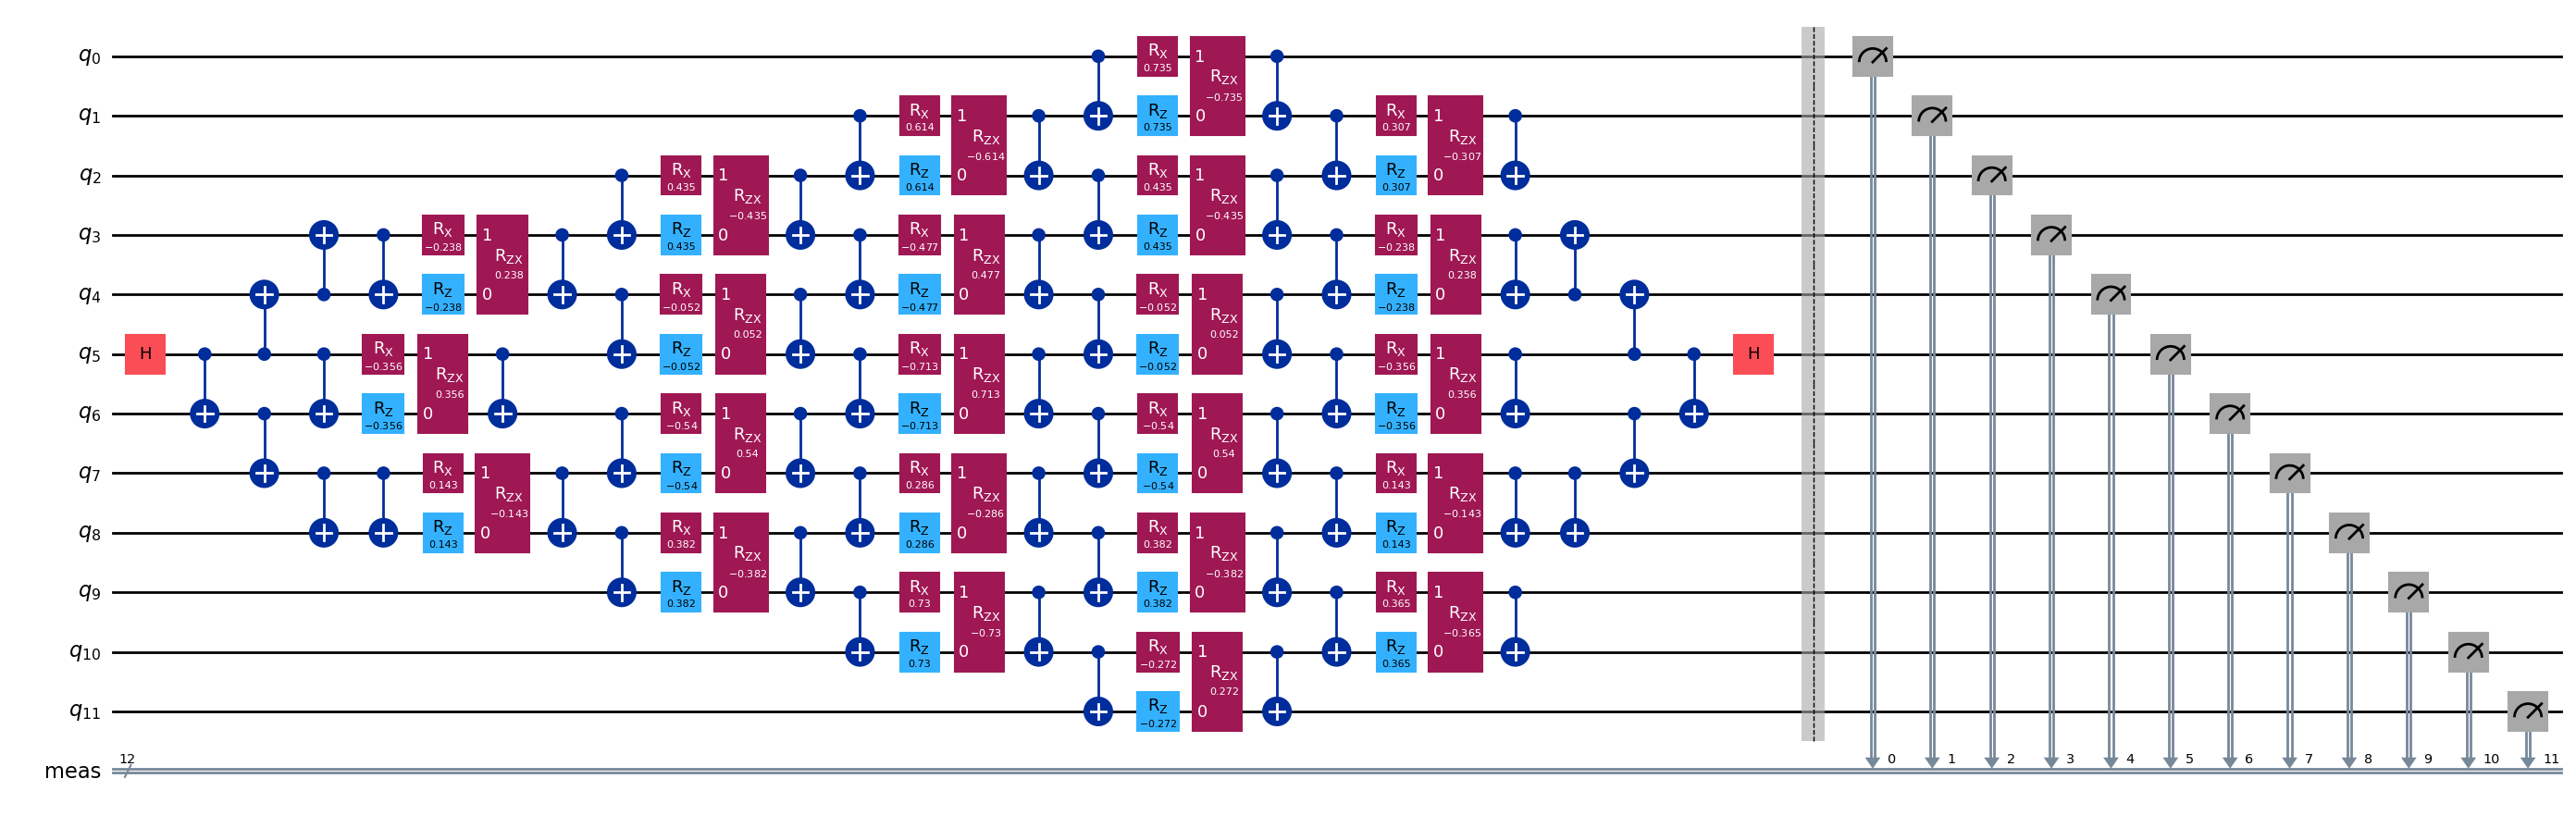

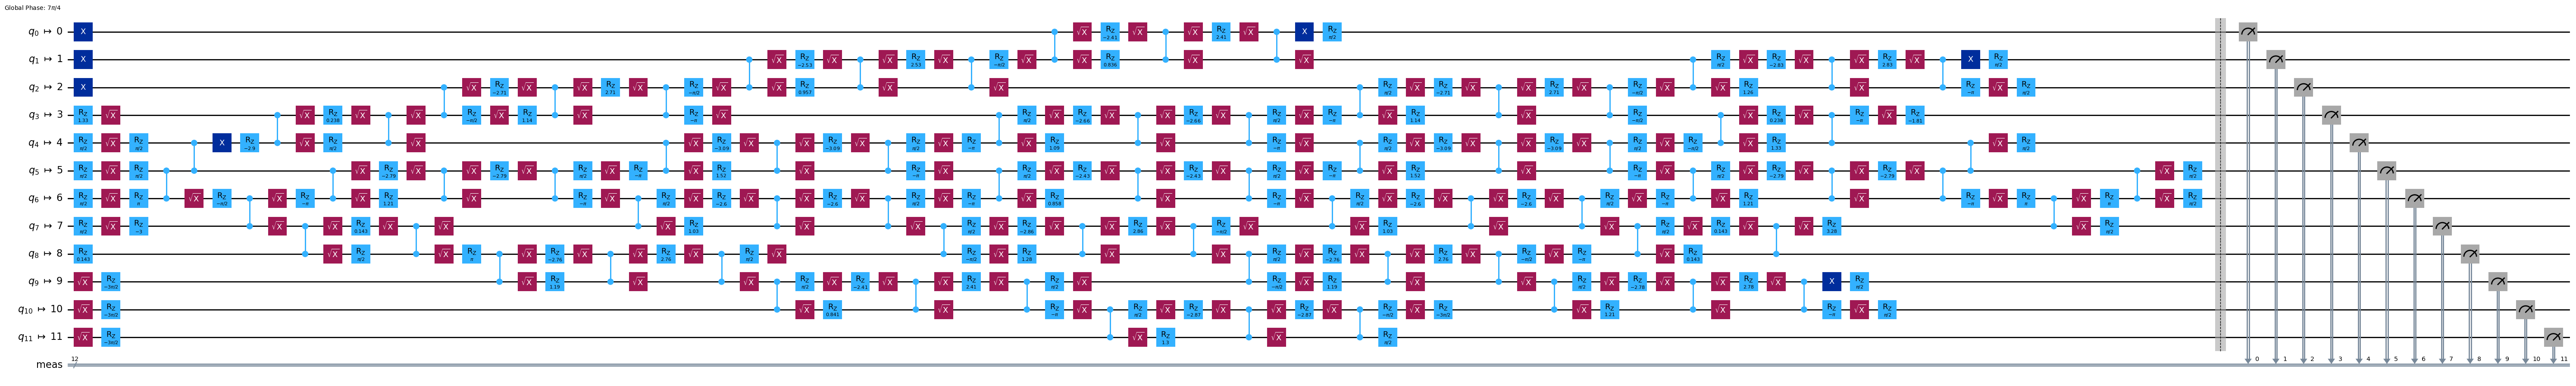

In [8]:
# For noisy simulator, we need job instances instead of job ids
_, jobs, _ = run_job(config)

In [9]:
features_df = get_features(config, jobs)
display(features_df)

Post-processing sample 0/55
Post-processing sample 1/55
Post-processing sample 2/55
Post-processing sample 3/55
Post-processing sample 4/55
Post-processing sample 5/55
Post-processing sample 6/55
Post-processing sample 7/55
Post-processing sample 8/55
Post-processing sample 9/55
Post-processing sample 10/55
Post-processing sample 11/55
Post-processing sample 12/55
Post-processing sample 13/55
Post-processing sample 14/55
Post-processing sample 15/55
Post-processing sample 16/55
Post-processing sample 17/55
Post-processing sample 18/55
Post-processing sample 19/55
Post-processing sample 20/55
Post-processing sample 21/55
Post-processing sample 22/55
Post-processing sample 23/55
Post-processing sample 24/55
Post-processing sample 25/55
Post-processing sample 26/55
Post-processing sample 27/55
Post-processing sample 28/55
Post-processing sample 29/55
Post-processing sample 30/55
Post-processing sample 31/55
Post-processing sample 32/55
Post-processing sample 33/55
Post-processing sample 3

Post-processing sample 38/55
Post-processing sample 39/55
Post-processing sample 40/55
Post-processing sample 41/55
Post-processing sample 42/55
Post-processing sample 43/55
Post-processing sample 44/55
Post-processing sample 45/55
Post-processing sample 46/55
Post-processing sample 47/55
Post-processing sample 48/55
Post-processing sample 49/55
Post-processing sample 50/55
Post-processing sample 51/55
Post-processing sample 52/55
Post-processing sample 53/55
Post-processing sample 54/55


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,...,f_7 Im,f_8 Re,f_8 Im,f_9 Re,f_9 Im,f_10 Re,f_10 Im,f_11 Re,f_11 Im,expected_value
0,0,0.937500,0.689587,-0.229130,0.469491,-0.368162,0.239895,-0.325551,0.094243,-0.163047,...,0.003858,0.059508,-0.077585,0.030263,-0.217255,-0.080562,-0.307849,-0.176784,-0.309825,0.792109
1,1,0.909180,0.755348,0.027183,0.667724,0.102088,0.535889,0.113561,0.343682,0.059963,...,-0.100874,-0.128379,-0.179023,-0.208711,-0.248033,-0.204621,-0.273028,-0.224936,-0.299190,1.102887
2,2,0.934570,0.773981,0.071705,0.714103,0.145320,0.610827,0.176676,0.467015,0.215232,...,0.110241,0.170245,0.106771,0.136615,0.035690,0.107147,0.067460,0.103760,0.065364,1.130663
3,3,0.919922,0.670222,0.245851,0.388215,0.339756,0.100387,0.256384,0.010913,0.039646,...,0.055958,0.041757,0.054545,0.121835,0.049488,0.159579,-0.005038,0.237930,0.077200,1.552866
4,4,0.922852,0.766576,0.100779,0.723552,0.160521,0.567209,0.230897,0.472385,0.269031,...,0.259081,0.085471,0.231618,-0.002232,0.123042,-0.082262,0.091590,-0.109548,0.062197,1.149036
5,5,0.913086,0.771073,0.207380,0.547459,0.325024,0.340856,0.341366,0.146112,0.237335,...,-0.096845,0.415100,-0.027654,0.339135,0.146516,0.278014,0.252555,0.132041,0.240608,1.332599
6,6,0.921875,0.686513,0.044433,0.466333,-0.003102,0.170926,-0.003787,-0.006125,0.022812,...,-0.180514,-0.185450,-0.175690,-0.210936,-0.050409,-0.103547,0.021334,-0.028725,0.016335,1.114135
7,7,0.910156,0.727865,-0.015345,0.553081,-0.041577,0.332008,-0.034057,0.074568,-0.024754,...,0.014798,0.032088,0.010350,-0.032437,-0.031215,-0.088108,-0.010192,-0.104024,0.026047,1.034106
8,8,0.919922,0.718727,0.226182,0.518480,0.352052,0.270094,0.330352,0.056931,0.248459,...,-0.015929,0.330963,0.055069,0.276631,0.085838,0.235371,0.133795,0.206065,0.207343,1.421492
9,9,0.917969,0.662896,-0.391488,0.405867,-0.628189,0.081692,-0.658197,-0.233871,-0.569205,...,0.065036,-0.282381,0.206357,-0.167096,0.219452,0.033685,0.241073,0.133769,0.183548,0.634733
